In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

eval_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/chi_eval_videos'
os.makedirs(eval_viz_cache_root, exist_ok=True)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = [                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',

 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500',  

 'classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',  
]

# Get vizualization for single session

In [4]:
sample_course = '05681A'
sample_session_id = 'classinsight-cmu_05681A_ghc_4301_201904171630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05681A/classinsight-cmu_05681A_ghc_4301_201904171630-front'

In [5]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


19 77
32 98
36 98
37 102
38 82
38 99
40 83
41 98
44 98
46 98
47 82
47 86
47 99
49 98
50 82
50 86
51 82
51 86
53 98
54 82
56 82
56 86
56 99
62 82
62 86
67 82
67 99
69 82
69 88
72 88
72 98
74 94
76 106
78 102
85 99
92 106
Dict: eligible_id_map_dict
Key: Value


{36: 32,
 41: 32,
 44: 32,
 46: 32,
 47: 38,
 49: 32,
 50: 47,
 51: 47,
 53: 32,
 54: 38,
 56: 38,
 62: 47,
 67: 38,
 69: 38,
 72: 32,
 77: 19,
 78: 37,
 82: 38,
 83: 40,
 85: 38,
 86: 47,
 88: 69,
 92: 76,
 94: 74,
 98: 32,
 99: 38,
 102: 37,
 106: 76}

Dict: eligible_id_map_dict
Key: Value


{36: 32,
 41: 32,
 44: 32,
 46: 32,
 47: 38,
 49: 32,
 50: 38,
 51: 38,
 53: 32,
 54: 38,
 56: 38,
 62: 38,
 67: 38,
 69: 38,
 72: 32,
 77: 19,
 78: 37,
 82: 38,
 83: 40,
 85: 38,
 86: 38,
 88: 38,
 92: 76,
 94: 74,
 98: 32,
 99: 38,
 102: 37,
 106: 76}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 621:36 -->32
replacing 1015:41 -->32
replacing 1241:44 -->32
replacing 1488:46 -->32
replacing 1622:47 -->38
replacing 1765:49 -->32
replacing 1835:50 -->38
replacing 1900:51 -->38
replacing 2136:53 -->32
replacing 2141:54 -->38
replacing 2524:56 -->38
replacing 3062:62 -->38
replacing 3355:67 -->38
replacing 3677:69 -->38
replacing 4054:72 -->32
replacing 4744:77 -->19
replacing 4784:78 -->37
replacing 5054:82 -->38
replacing 5078:83 -->40
replacing 5165:85 -->38
replacing 5296:86 -->38
replacing 5498:88 -->38
replacing 5679:92 -->76
replacing 5854:94 -->74
replacing 6026:98 -->32
replacing 6115:99 -->38
replacing 6250:102 -->37
replacing 6379:106 -->76
replacing 783:36 -->32
replacing 944:36 -->32
replacing 966:36 -->32
replacing 1229:36 -->32
replacing 1112:41 -->32
replacing 1611:46 -->32
replacing 1660:47 -->38
replacing 1656:46 -->32
replacing 1778:47 -->38
replacing 2113:51 -->38
replacing 2159

In [6]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [7]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,3564,3564
1,1,0,1014,1014
2,2,0,6126,6126
3,3,0,36309,36309
4,4,0,85680,85680
...,...,...,...,...
75,101,80526,85680,5154
76,103,82026,84960,2934
77,104,82227,85680,3453
78,105,82734,85680,2946


In [8]:
df_id_start_stop.total_idxs.max()*0.1

8568.0

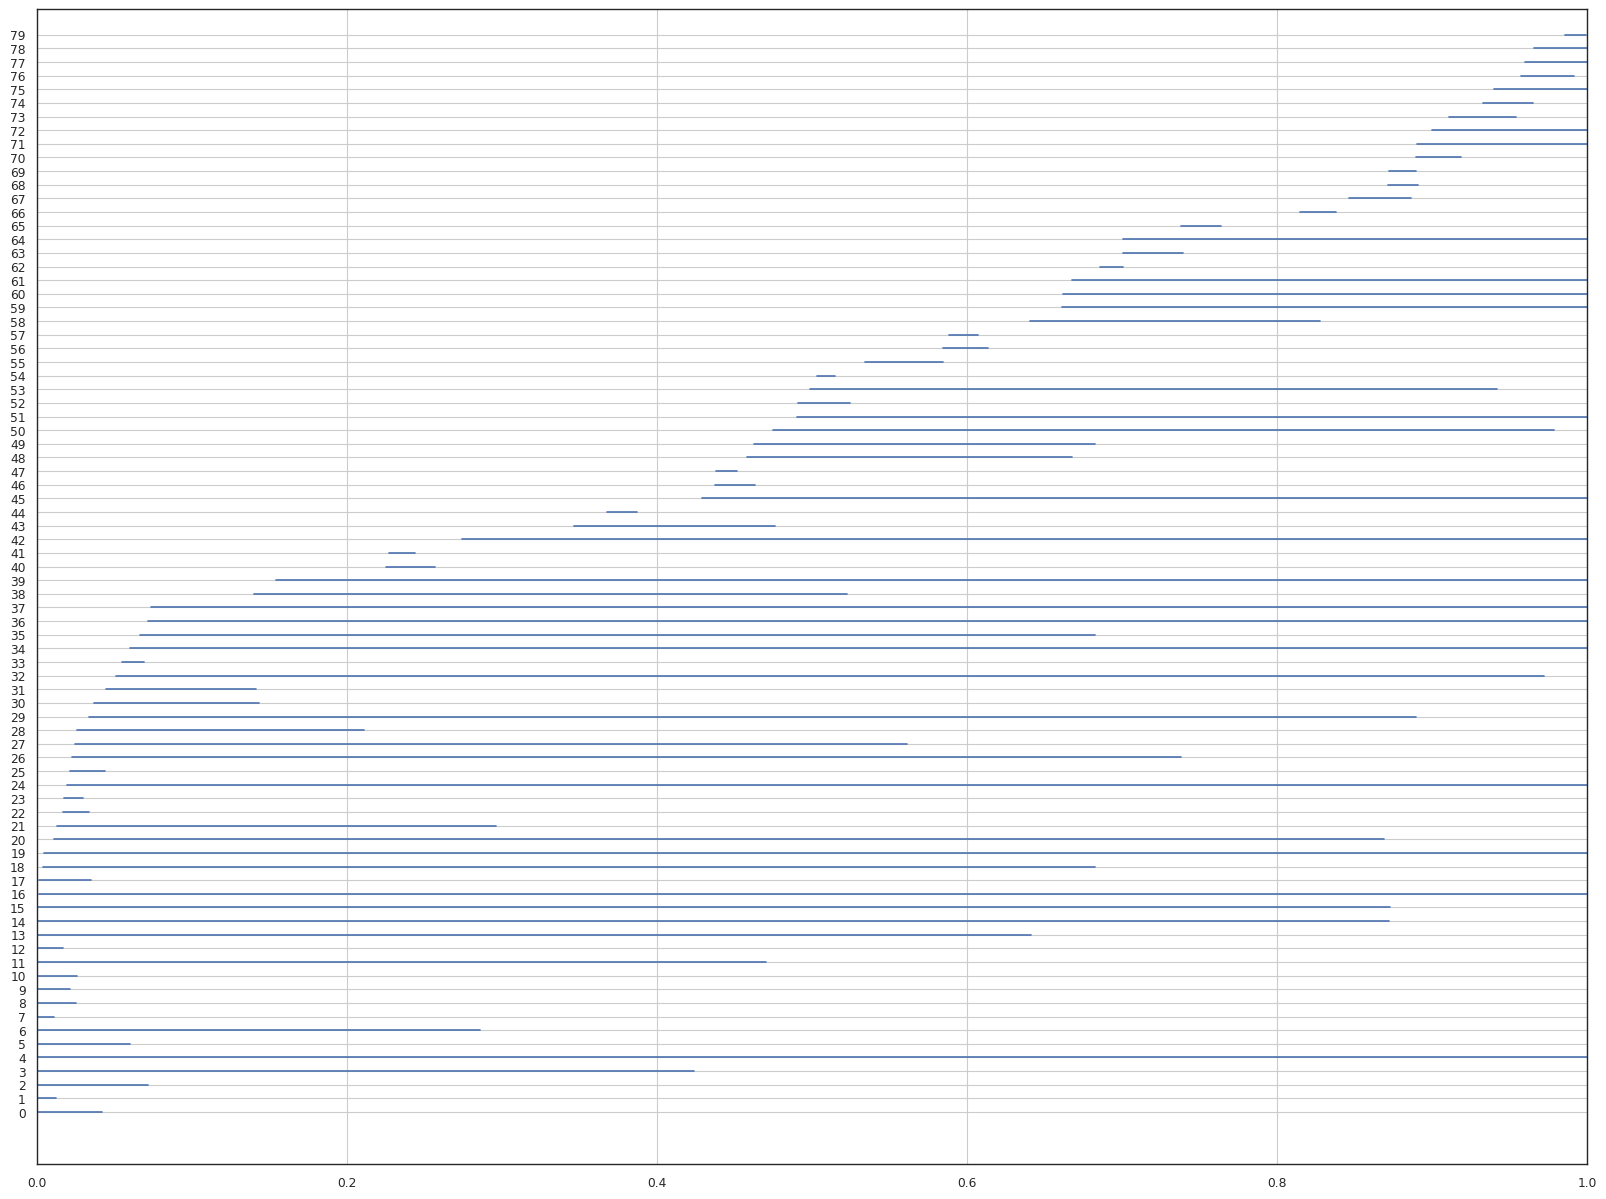

In [9]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [10]:
INSTRUCTOR_ID_THRESHOLD = df_id_start_stop.total_idxs.max()*0.1
instructor_ids = df_id_start_stop[df_id_start_stop.total_idxs < INSTRUCTOR_ID_THRESHOLD]['id'].values
instructor_ids

array([  0,   1,   2,   5,   7,   8,   9,  10,  12,  17,  22,  23,  25,
        31,  33,  42,  43,  52,  57,  58,  64,  66,  68,  70,  71,  79,
        80,  84,  87,  89,  90,  91,  93,  97, 100, 101, 103, 104, 105,
       107])

In [11]:
# find random frames to mark for GT from session
# np.random.seed(42)

MAX_SESSION_IDX = df_id_start_stop.max_idx.max()
NUM_SEGMENTS =3
SEG_START_MIN = 0.1
SEG_START_MAX=0.9
SET_SIZE = 60*15
SEGMENT_WINDOW_SIZE = (SEG_START_MAX - SEG_START_MIN)/NUM_SEGMENTS

session_frames = df_tracking_new.index.values.tolist()
selected_frames = []
selected_sets = []

for i in range(NUM_SEGMENTS):    
    seg_window =  np.arange(int((SEG_START_MIN + (i*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX), int((SEG_START_MIN + ((i+1)*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX) - SET_SIZE) 
    seg_set_start = np.random.choice(seg_window)
    seg_set_end = seg_set_start+SET_SIZE
    segment_frames = [xr for xr in session_frames if ((xr >= seg_set_start) and (xr<seg_set_end))]
    selected_sets.append((seg_set_start, seg_set_end, segment_frames))
    selected_frames+=segment_frames        

sprint(selected_sets)

List: selected_sets


[
    (
        9155,
        10055,
        [
            9156,
            9159,
            9162,
            9165,
            9168,
            9171,
            9174,
            9177,
            9180,
            9183,
            9186,
            9189,
            9192,
            9195,
            9198,
            9201,
            9204,
            9207,
            9210,
            9213,
            9216,
            9219,
            9222,
            9225,
            9228,
            9231,
            9234,
            9237,
            9240,
            9243,
            9246,
            9249,
            9252,
            9255,
            9258,
            9261,
            9264,
            9267,
            9270,
            9273,
            9276,
            9279,
            9282,
            9285,
            9288,
            9291,
            9294,
            9297,
            9300,
            9303,
            9306,
            9309,
            9312,
            9315,
            9318,
            9321,
            9324,
            9327,
            9330,
            9333,
            9336,
            9339,
            9342,
            9345,
            9348,
            9351,
            9354,
            9357,
            9360,
            9363,
            9366,
            9369,
            9372,
            9375,
            9378,
            9381,
            9384,
            9387,
            9390,
            9393,
            9396,
            9399,
            9402,
            9405,
            9408,
            9411,
            9414,
            9417,
            9420,
            9423,
            9426,
            9429,
            9432,
            9435,
            9438,
            9441,
            9444,
            9447,
            9450,
            9453,
            9456,
            9459,
            9462,
            9465,
            9468,
            9471,
            9474,
            9477,
            9480,
            9483,
            9486,
            9489,
            9492,
            9495,
            9498,
            9501,
            9504,
            9507,
            9510,
            9513,
            9516,
            9519,
            9522,
            9525,
            9528,
            9531,
            9534,
            9537,
            9540,
            9543,
            9546,
            9549,
            9552,
            9555,
            9558,
            9561,
            9564,
            9567,
            9570,
            9573,
            9576,
            9579,
            9582,
            9585,
            9588,
            9591,
            9594,
            9597,
            9600,
            9603,
            9606,
            9609,
            9612,
            9615,
            9618,
            9621,
            9624,
            9627,
            9630,
            9633,
            9636,
            9639,
            9642,
            9645,
            9648,
            9651,
            9654,
            9657,
            9660,
            9663,
            9666,
            9669,
            9672,
            9675,
            9678,
            9681,
            9684,
            9687,
            9690,
            9693,
            9696,
            9699,
            9702,
            9705,
            9708,
            9711,
            9714,
            9717,
            9720,
            9723,
            9726,
            9729,
            9732,
            9735,
            9738,
            9741,
            9744,
            9747,
            9750,
            9753,
            9756,
            9759,
            9762,
            9765,
            9768,
            9771,
            9774,
            9777,
            9780,
            9783,
            9786,
            9789,
            9792,
            9795,
            9798,
            9801,
            9804,
            9807,
            9810,
           

In [12]:
len(selected_frames)

900

In [13]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [14]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xa374500] error while decoding MB 148 36, bytestream -17
[h264 @ 0xa374500] error while decoding MB 155 99, bytestream -5
[h264 @ 0xa374500] error while decoding MB 191 115, bytestream -5
[h264 @ 0xa1b2400] error while decoding MB 148 36, bytestream -17
[h264 @ 0xa168580] error while decoding MB 155 99, bytestream -5
[h264 @ 0xa512b00] error while decoding MB 191 115, bytestream -5
[h264 @ 0xa54f800] error while decoding MB 133 92, bytestream -9
[h264 @ 0xa1b2400] error while decoding MB 148 36, bytestream -17
[h264 @ 0xa168580] error while decoding MB 155 99, bytestream -5
[h264 @ 0xa512b00] error while decoding MB 191 115, bytestream -5
[h264 @ 0xa54f800] error while decoding MB 133 92, bytestream -9


Looped 0 images


[h264 @ 0xec12880] error while decoding MB 219 65, bytestream -6
[h264 @ 0xedb0f00] error while decoding MB 106 59, bytestream -15
[h264 @ 0xa1b6f00] error while decoding MB 191 48, bytestream -7
[h264 @ 0xa168580] error while decoding MB 71 48, bytestream -6
[h264 @ 0xa512b00] error while decoding MB 7 45, bytestream -6
[h264 @ 0xa53b300] error while decoding MB 56 46, bytestream -9
[h264 @ 0xa563d00] error while decoding MB 15 52, bytestream -9


Looped 10000 images


[h264 @ 0xa1b6f00] error while decoding MB 120 94, bytestream -11
[h264 @ 0xa168580] error while decoding MB 103 76, bytestream -6
[h264 @ 0xa58c700] error while decoding MB 21 83, bytestream -5
[h264 @ 0xa17c980] error while decoding MB 7 56, bytestream -28
[h264 @ 0xa526f00] error while decoding MB 142 58, bytestream -11
[h264 @ 0xa54f800] error while decoding MB 16 80, bytestream -13
[h264 @ 0xa578200] error while decoding MB 75 58, bytestream -9
[h264 @ 0xa5a0c00] error while decoding MB 124 53, bytestream -22
[h264 @ 0xece1bc0] error while decoding MB 95 51, bytestream -19
[h264 @ 0xa379300] error while decoding MB 171 41, bytestream -8
[h264 @ 0xa1b2400] error while decoding MB 182 44, bytestream -22


Looped 20000 images


[h264 @ 0xa17c980] error while decoding MB 84 26, bytestream -7
[h264 @ 0xa526f00] error while decoding MB 72 24, bytestream -33
[h264 @ 0xa54f800] error while decoding MB 83 45, bytestream -13
[h264 @ 0xa578200] error while decoding MB 62 38, bytestream -38
[h264 @ 0xa5a0c00] error while decoding MB 36 1, bytestream -10
[h264 @ 0xece1bc0] error while decoding MB 161 109, bytestream -27
[h264 @ 0xa379300] error while decoding MB 10 40, bytestream -16
[h264 @ 0xa1b2400] error while decoding MB 132 45, bytestream -31
[h264 @ 0xa17c980] error while decoding MB 83 109, bytestream -22
[h264 @ 0xa526f00] error while decoding MB 98 102, bytestream -8
[h264 @ 0xa54f800] error while decoding MB 227 109, bytestream -8
[h264 @ 0xa58c700] error while decoding MB 62 45, bytestream -15
[h264 @ 0xece1bc0] error while decoding MB 104 102, bytestream -22
[h264 @ 0xa379300] error while decoding MB 169 109, bytestream -12
[h264 @ 0xa1b2400] error while decoding MB 211 107, bytestream -13
[h264 @ 0xa17c98

Looped 30000 images


[h264 @ 0xa379300] error while decoding MB 178 109, bytestream -26
[h264 @ 0xa1b2400] error while decoding MB 238 108, bytestream -5
[h264 @ 0xa17c980] error while decoding MB 49 93, bytestream -6
[h264 @ 0xa526f00] error while decoding MB 141 101, bytestream -25
[h264 @ 0xa54f800] error while decoding MB 200 108, bytestream -26
[h264 @ 0xa58c700] error while decoding MB 122 34, bytestream -5
[h264 @ 0xa5a0c00] error while decoding MB 215 130, bytestream -10
[h264 @ 0xece1bc0] error while decoding MB 126 94, bytestream -17
[h264 @ 0xa379300] error while decoding MB 217 101, bytestream -9
[h264 @ 0xa1b2400] error while decoding MB 72 101, bytestream -19
[h264 @ 0xa17c980] error while decoding MB 55 94, bytestream -23
[h264 @ 0xa526f00] error while decoding MB 100 52, bytestream -23
[h264 @ 0xa54f800] error while decoding MB 142 101, bytestream -19
[h264 @ 0xa578200] error while decoding MB 148 132, bytestream -22
[h264 @ 0xec12880] error while decoding MB 154 29, bytestream -11
[h264 @ 

Looped 40000 images


[h264 @ 0xa5a0c00] error while decoding MB 155 120, bytestream -5
[h264 @ 0xece1bc0] error while decoding MB 37 93, bytestream -32
[h264 @ 0xa379300] error while decoding MB 171 87, bytestream -11
[h264 @ 0xa1b2400] error while decoding MB 61 87, bytestream -11
[h264 @ 0xa17c980] error while decoding MB 200 91, bytestream -9
[h264 @ 0xa526f00] error while decoding MB 13 92, bytestream -7
[h264 @ 0xa54f800] error while decoding MB 142 86, bytestream -7
[h264 @ 0xa58c700] error while decoding MB 124 22, bytestream -13
[h264 @ 0xa5a0c00] error while decoding MB 95 91, bytestream -6
[h264 @ 0xece1bc0] error while decoding MB 192 73, bytestream -22
[h264 @ 0xa379300] error while decoding MB 100 74, bytestream -16
[h264 @ 0xa1b2400] error while decoding MB 96 73, bytestream -26
[h264 @ 0xa17c980] error while decoding MB 63 87, bytestream -20
[h264 @ 0xa526f00] error while decoding MB 120 59, bytestream -16
[h264 @ 0xa54f800] error while decoding MB 38 92, bytestream -11
[h264 @ 0xa578200] er

Looped 50000 images


[h264 @ 0xa58c700] error while decoding MB 193 26, bytestream -5
[h264 @ 0xec12880] error while decoding MB 98 27, bytestream -11
[h264 @ 0xece1bc0] error while decoding MB 183 117, bytestream -9
[h264 @ 0xa379300] error while decoding MB 199 12, bytestream -14
[h264 @ 0xa1b2400] cabac decode of qscale diff failed at 189 109
[h264 @ 0xa1b2400] error while decoding MB 189 109, bytestream -8
[h264 @ 0xa17c980] error while decoding MB 88 107, bytestream -12
[h264 @ 0xa526f00] error while decoding MB 88 117, bytestream -22
[h264 @ 0xa54f800] error while decoding MB 227 109, bytestream -14
[h264 @ 0xa58c700] error while decoding MB 73 35, bytestream -9
[h264 @ 0xec12880] error while decoding MB 134 28, bytestream -5
[h264 @ 0xece1bc0] error while decoding MB 237 115, bytestream -19
[h264 @ 0xa379300] error while decoding MB 193 99, bytestream -9
[h264 @ 0xa1b2400] error while decoding MB 177 100, bytestream -9
[h264 @ 0xa17c980] error while decoding MB 48 101, bytestream -11
[h264 @ 0xa526f

Looped 60000 images


[h264 @ 0xa526f00] error while decoding MB 102 109, bytestream -17
[h264 @ 0xa54f800] error while decoding MB 54 101, bytestream -17
[h264 @ 0xece1bc0] error while decoding MB 142 99, bytestream -21
[h264 @ 0xa379300] error while decoding MB 65 92, bytestream -5
[h264 @ 0xa1b2400] error while decoding MB 148 92, bytestream -12
[h264 @ 0xa17c980] error while decoding MB 203 92, bytestream -21
[h264 @ 0xa526f00] error while decoding MB 85 101, bytestream -50
[h264 @ 0xa54f800] error while decoding MB 117 92, bytestream -15
[h264 @ 0xa58c700] error while decoding MB 135 37, bytestream -5
[h264 @ 0xec12880] error while decoding MB 72 34, bytestream -5
[h264 @ 0xece1bc0] error while decoding MB 155 99, bytestream -20
[h264 @ 0xa379300] error while decoding MB 187 92, bytestream -21
[h264 @ 0xa1b2400] error while decoding MB 112 93, bytestream -32
[h264 @ 0xa17c980] error while decoding MB 84 94, bytestream -21
[h264 @ 0xa526f00] error while decoding MB 10 101, bytestream -7
[h264 @ 0xa54f80

Looped 70000 images


[h264 @ 0xa1b2400] error while decoding MB 162 85, bytestream -14
[h264 @ 0xa17c980] error while decoding MB 89 85, bytestream -5
[h264 @ 0xa526f00] error while decoding MB 43 93, bytestream -10
[h264 @ 0xa54f800] error while decoding MB 55 85, bytestream -20
[h264 @ 0xa578200] error while decoding MB 236 97, bytestream -12
[h264 @ 0xa5a0c00] error while decoding MB 103 92, bytestream -8
[h264 @ 0xece1bc0] error while decoding MB 232 76, bytestream -18
[h264 @ 0xa379300] error while decoding MB 55 62, bytestream -11
[h264 @ 0xa1b2400] error while decoding MB 124 85, bytestream -27
[h264 @ 0xa17c980] error while decoding MB 49 84, bytestream -18
[h264 @ 0xa526f00] error while decoding MB 228 80, bytestream -17
[h264 @ 0xa54f800] error while decoding MB 33 69, bytestream -8
[h264 @ 0xa578200] error while decoding MB 228 117, bytestream -6
[h264 @ 0xa5a0c00] error while decoding MB 71 60, bytestream -6
[h264 @ 0xece1bc0] error while decoding MB 159 79, bytestream -22
[h264 @ 0xa379300] er

Looped 80000 images


[h264 @ 0xece1bc0] error while decoding MB 38 46, bytestream -17
[h264 @ 0xa379300] error while decoding MB 140 45, bytestream -17
[h264 @ 0xa1b2400] error while decoding MB 172 32, bytestream -13
[h264 @ 0xa17c980] error while decoding MB 143 31, bytestream -18
[h264 @ 0xa526f00] error while decoding MB 217 46, bytestream -37
[h264 @ 0xa54f800] error while decoding MB 83 26, bytestream -10
[h264 @ 0xa578200] error while decoding MB 172 33, bytestream -11
[h264 @ 0xa5a0c00] error while decoding MB 74 29, bytestream -34
[h264 @ 0xece1bc0] error while decoding MB 161 25, bytestream -5
[h264 @ 0xa379300] error while decoding MB 93 23, bytestream -42
[h264 @ 0xa1b2400] error while decoding MB 32 18, bytestream -16
[h264 @ 0xa17c980] error while decoding MB 214 101, bytestream -10
[h264 @ 0xa526f00] error while decoding MB 47 109, bytestream -17
[h264 @ 0xa54f800] error while decoding MB 172 101, bytestream -8
[h264 @ 0xa58c700] error while decoding MB 10 33, bytestream -5
[h264 @ 0xec12880

Looped 90000 images


[h264 @ 0xec12880] error while decoding MB 173 33, bytestream -9
[h264 @ 0xece1bc0] error while decoding MB 185 107, bytestream -6
[h264 @ 0xa379300] error while decoding MB 119 99, bytestream -9
[h264 @ 0xa1b2400] error while decoding MB 80 94, bytestream -16
[h264 @ 0xa17c980] error while decoding MB 208 91, bytestream -15
[h264 @ 0xa526f00] error while decoding MB 172 101, bytestream -12
[h264 @ 0xa54f800] error while decoding MB 101 93, bytestream -25
[h264 @ 0xa58c700] error while decoding MB 133 31, bytestream -5
[h264 @ 0xec12880] error while decoding MB 41 35, bytestream -7
[h264 @ 0xece1bc0] error while decoding MB 200 101, bytestream -21
[h264 @ 0xa379300] error while decoding MB 48 85, bytestream -14
[h264 @ 0xa1b2400] error while decoding MB 178 91, bytestream -5
[h264 @ 0xa17c980] error while decoding MB 197 93, bytestream -9
[h264 @ 0xa526f00] error while decoding MB 161 99, bytestream -13
[h264 @ 0xa54f800] error while decoding MB 152 90, bytestream -42
[h264 @ 0xa58c700

In [15]:
import cv2
session_id_viz_dir = f'{eval_viz_cache_root}/{sample_session_id}'
font = cv2.FONT_HERSHEY_DUPLEX
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, segment_frames) in enumerate(selected_sets):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                new_id = old_to_new_id_map[old_id]
                if new_id in instructor_ids:
                    new_id = 1000+new_id
                frame_tracking_results[person_idx]['track_id'] =new_id
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_img = cv2.putText(frame_img,
                   f'frame_idx:{frame_idx}',
                   (frame_img.shape[1]//2, frame_img.shape[0]//2+1000),
                   font, 2,
                   (255, 255, 255),
                   2)
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
                # cv2.imwrite(f'frame_test/{frame_idx}.jpg',frame_track_img)
            else:
                cv2.imwrite(frame_file_out,frame_img)
                
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=10, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-11-14 12:32:06,856 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-11-14 12:32:07,096 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-11-14 12:32:07,097 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-11-14 12:32:07,099 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-11-14 12:32:08,494 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector